# Getting the residential registry


* Based on official data from the Swedish Land Registry (_Lantmäteriet_), but managed and improved by Valueguard and available through our easy to use API.
* The residential registry contains more than 5.6 million homes in Sweden, of which **2.1 million** are houses and **2.7 million** are apartments. 
* We have correctly coded **85** percent of all tenancies and **99** percent of all cooperative housing.
* We update the registry every quarter
* The variable "construction_year" is missing on 9 percent of houses (2-4 percent missing for houses built 1980 and earlier) and 30 percent of apartments, a total of **22** percent of all homes. It is possible to mark up the build year in around 20 percent of these objects by using swedb_markup (sales and ads).
* The registry is complete with number of rooms and kitchen type for apartments

## Install dependencies

In [1]:
# Install valueguards client
!pip install git+https://github.com/Valueguard-Index-Sweden/valueguard-python-client#egg=valueguard
# Install tqdm progress bar 
!pip install tqdm
# Install folium map
!pip install folium
# Install pymysql
!pip install pymysql

  Cloning https://github.com/Valueguard-Index-Sweden/valueguard-python-client to /tmp/pip-install-0jq_of59/valueguard_dc415422644c4263870ab842b4736216
  Running command git clone -q https://github.com/Valueguard-Index-Sweden/valueguard-python-client /tmp/pip-install-0jq_of59/valueguard_dc415422644c4263870ab842b4736216


## Import libraries 

- **valueguard** our official client to retrive data from the API
- **tqdm** for a easily understandable progressbar
- **pandas** to work with the data in python
- **math** to calcualate the ceiling of pages needed
- **time** to time the functions
- **sqlalchemy** to store the data in a database
- **Folium** Visualize the data on a map

In [2]:
import valueguard
from tqdm import tqdm
import pandas as pd
import math
import time
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import folium
from folium import Marker
from folium.plugins import MarkerCluster
import os

### Display Settings

In [3]:
pd.set_option('display.max_columns', None)

### Create client object

In [4]:
vgClient = valueguard.Client()

### Get credentials 

In [5]:
valueguard_username = os.getenv('VALUEGUARD_API_USERNAME')
valueguard_password = os.getenv('VALUEGUARD_API_PASSWORD')

### Login to Valueguard

In [6]:
vgClient.authenticate(valueguard_username,valueguard_password)

## Settings for the **residential registry**

> We are fetching the entire residential registry. 

We use a **page size** of **50000 rows** and divide it by the total number of rows returned from the search criteria that was sent in. 

Search criteria will be empty since we want everything.

The possible search criteria can be found here: [Search criterias](https://github.com/Valueguard-Index-Sweden/valueguard-python-client/wiki/residential-registry#search-criteria-fields)

In [7]:
residential_registry_search_criteria={}

residential_registry_total_nr_records = vgClient.residential_registry(offset=0, limit=0, search_criteria=residential_registry_search_criteria)['meta_data']['total_nr_records']
page_size = 50000

pages = math.ceil(residential_registry_total_nr_records/page_size)

## Fetching the **residential registry**

> We loop over all the pages and add the result to our dataframe

The amount of fields retrieved depends on your account.

The possible column that can be fetched can be found here: [Residential registry columns](https://github.com/Valueguard-Index-Sweden/valueguard-python-client/wiki/residential-registry#field-list)


In [8]:
# Start time to calculate the runtime
start = time.time()
# Dataframe to store the data
residential_registry_df = pd.DataFrame()
# We use tqdm to get a progessbar
for page_nr in tqdm(range(pages)):
    # There might be some connection issues that would stop the fetch, so we rerun those until it works.
    successful_fetch = True
    while successful_fetch:
        try:
          residential_registry_df = residential_registry_df.append(pd.DataFrame(vgClient.residential_registry(offset=page_nr*page_size, limit=page_size, search_criteria=residential_registry_search_criteria)['residences']), ignore_index=True)
          successful_fetch=False
        except:
          pass 
#    
end = time.time()
print("Fetch time: " + str((end - start)/60) + "min")

100%|██████████| 117/117 [1:49:28<00:00, 56.14s/it]

Fetch time: 109.46830709775288min


### Check if we have fetched all rows

In [9]:
len(residential_registry_df) == residential_registry_total_nr_records

True

#### Set the id field to index

In [10]:
residential_registry_df.set_index('id', inplace=True)

## Investigating the data

> Search on **street = Kantorsgatan** and **postal code  = 75424**

In [11]:
residential_registry_df_search = residential_registry_df[(residential_registry_df['street'] == 'Kantorsgatan') & (residential_registry_df['postal_code'] == "75424")][['address','street','apartment_nr','home_type','updated_from', 'updated_at','wgs84lon','wgs84lat']]
residential_registry_df_search

,address,street,apartment_nr,home_type,updated_from,updated_at,wgs84lon,wgs84lat
id,,,,,,,,
2977071,"Kantorsgatan 26, 75424",Kantorsgatan,1001.0,lägenhet,public_data,2018-08-31,17.643617,59.873356
2977072,"Kantorsgatan 26, 75424",Kantorsgatan,1002.0,lägenhet,public_data,2018-08-31,17.643617,59.873356
2977067,"Kantorsgatan 26, 75424",Kantorsgatan,1003.0,lägenhet,public_data,2018-08-31,17.643617,59.873356
2977058,"Kantorsgatan 26, 75424",Kantorsgatan,1004.0,lägenhet,public_data,2018-08-31,17.643617,59.873356
2977073,"Kantorsgatan 26, 75424",Kantorsgatan,1005.0,lägenhet,public_data,2018-08-31,17.643617,59.873356
...,...,...,...,...,...,...,...,...
2977632,"Kantorsgatan 68, 75424",Kantorsgatan,1502.0,lägenhet,public_data,2016-06-19,17.645731,59.873421
2977630,"Kantorsgatan 68, 75424",Kantorsgatan,1503.0,lägenhet,public_data,2016-06-19,17.645731,59.873421
2977633,"Kantorsgatan 68, 75424",Kantorsgatan,1504.0,lägenhet,public_data,2016-06-19,17.645731,59.873421


### Visualize search result on a map

In [12]:
# Create a map
m_1 = folium.Map(location=[59.87370948497286, 17.644212561349246], tiles='cartodbpositron', zoom_start=15)

# Add points to the map
mc = MarkerCluster()
for idx, row in residential_registry_df_search.iterrows():
    if not math.isnan(row['wgs84lon']) and not math.isnan(row['wgs84lat']):
        mc.add_child(Marker([row['wgs84lat'], row['wgs84lon']],popup=row['address'] + " lgh " + str(int(row['apartment_nr']))))
m_1.add_child(mc)
# Display the map
m_1


### Ownership type

Text(0.5, 1.0, 'Distribution of ownership types')

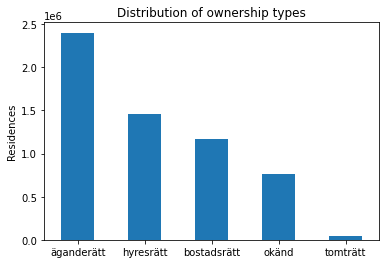

In [13]:
# create the bar plot
ax = residential_registry_df['ownership_type'].value_counts().plot(kind='bar')
# rotate xtick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# set the y-axis label
ax.set_ylabel("Residences")
# set the title
ax.set_title("Distribution of ownership types")

## Save data

### CSV (File)

In [14]:
residential_registry_df.to_csv("../data/residential_registry.csv")

### MySql (Database)

In [15]:
# Credentials to database connection
hostname="localhost"
dbname="mydb_name"
uname="my_user_name"
pwd="my_password"


# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))

# Convert dataframe to sql table                                   
# --> residential_registry_df.to_sql('residential_registry', engine, index=False)